#**1) EXPLORATIVE DATA ANALYSIS**

---


In [1]:
%%capture
!pip install -U spaCy
!python -m spacy download it_core_news_lg
!pip install transformers

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import string
import re
import requests
import random

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns
import matplotlib.colors as mcolors

# Pre-processing
import spacy
from spacy.lang.it import Italian
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora import Dictionary
from multiprocessing import cpu_count
import gensim.downloader as api
# Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Models and utils
from sklearn.preprocessing import MinMaxScaler
# Tensorflow-keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# BERT
import torch
from transformers import BertTokenizer, BertModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [64]:
BASE_PATHS = [
    # Base paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/',

    # Base paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/'
]

IMAGES_PATHS = [
    # Images paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/images_task1_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/images_task2_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/images_task3_train/',

    # Images paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/3_test/'
]

FILENAMES = [
    # Files for training
    'dankmemes_task1_train.csv',
    'dankmemes_task2_train.csv',
    'dankmemes_task3_train.csv',
    'dankmemes_task1_train_embeddings.csv',
    'dankmemes_task2_train_embeddings.csv',
    'dankmemes_task3_train_embeddings.csv',

    # Files for testing
    'meme_test_final.csv',
    'hate_test_final.csv',
    'event_test_final.csv',
    '1_test_embeddings.csv',
    '2_test_embeddings.csv',
    '3_test_embeddings_fixed.csv',

    # Utils
    'italian-swear-words-list_comma-separated-text-file.txt',

    # Testing task 2 with labels
    'hate_test_gold_standards.csv'
]

In [65]:
task_1_train = pd.read_csv(BASE_PATHS[0] + FILENAMES[0])
task_2_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[1])
task_3_train = pd.read_csv(BASE_PATHS[2] + FILENAMES[2])

task_1_test = pd.read_csv(BASE_PATHS[3] + FILENAMES[6])
task_2_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[7])
task_3_test = pd.read_csv(BASE_PATHS[5] + FILENAMES[8])

task_2_standard = pd.read_csv(BASE_PATHS[4] + FILENAMES[13])

In [5]:
task_1_train.head()

,File,Engagement,Date,Manipulation,Visual,Text,Meme
0,0.jpg,11,2019-08-12,1,Salvini,satira cruda votaci.. saremo di parola il part...,1
1,1.jpg,2261,2019-08-21,0,0,"peccato per le accise, dai. c'eravamo quasi.",0
2,2.jpg,1327,2019-08-23,0,"Salvini, Di Maio","""che c'è ancora?"" ""aspetto un bambino""",1
3,3.jpg,18,2019-08-27,0,0,ora in onda speciale gr1 ascolta la diretta se...,0
4,4.jpg,617,2019-08-25,0,"Salvini, Di Maio",sta sciocchezza che sto pe fa e solo colpa tua,1


In [6]:
task_2_train.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,1000.jpg,381,0,0,quando ti chiedono se sia peggiore fratelli d'...,1
1,1001.jpg,142,1,0,conte entra in un negozio di telefonia e passa...,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",i politicanti italici non vedono l'ora di anda...,1
3,1003.jpg,165,1,"Salvini, Renzi",sono scemo. io di più. scemo & più scemo,1
4,1004.jpg,44,0,0,"beppe grillo (2017) genova, 21 luglio 1948 pol...",0


In [7]:
task_3_train.head()

,File,Engagement,Date,Macro,Manipulation,Visual,Text,Event
0,2000.jpg,994,2019-05-09,0,1,Lega,suca salvini rosica,0
1,2001.jpg,20,2019-08-29,0,0,0,"in nome del popolo italiano, i cittadini itali...",0
2,2002.jpg,15,2016-07-08,0,0,0,"vladimir, ti interessa l'affare immigrati? asc...",0
3,2003.jpg,9,2019-08-29,0,0,"Meloni, Mattarella","""ma come chi sono? presidè sò io senza fotosci...",2
4,2004.jpg,12,2019-01-31,0,0,0,"cos'era? un topo di fogna? ah...no, salvini.",0


In [66]:
task_2_standard.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,5000.jpg,41,0,0,ogni singolo pensiero di salvini,1
1,5001.jpg,7,1,Salvini,per un nuovo governo: facile.it governare è fa...,0
2,5002.jpg,22,0,Lega,la lega a roma? e poi sarei io er monnezza! er...,1
3,5003.jpg,137,1,Conte,internazionale può funzionare un'alleanza tra ...,0
4,5004.jpg,2667,0,PD,esempi di cose che si autodistruggono,1


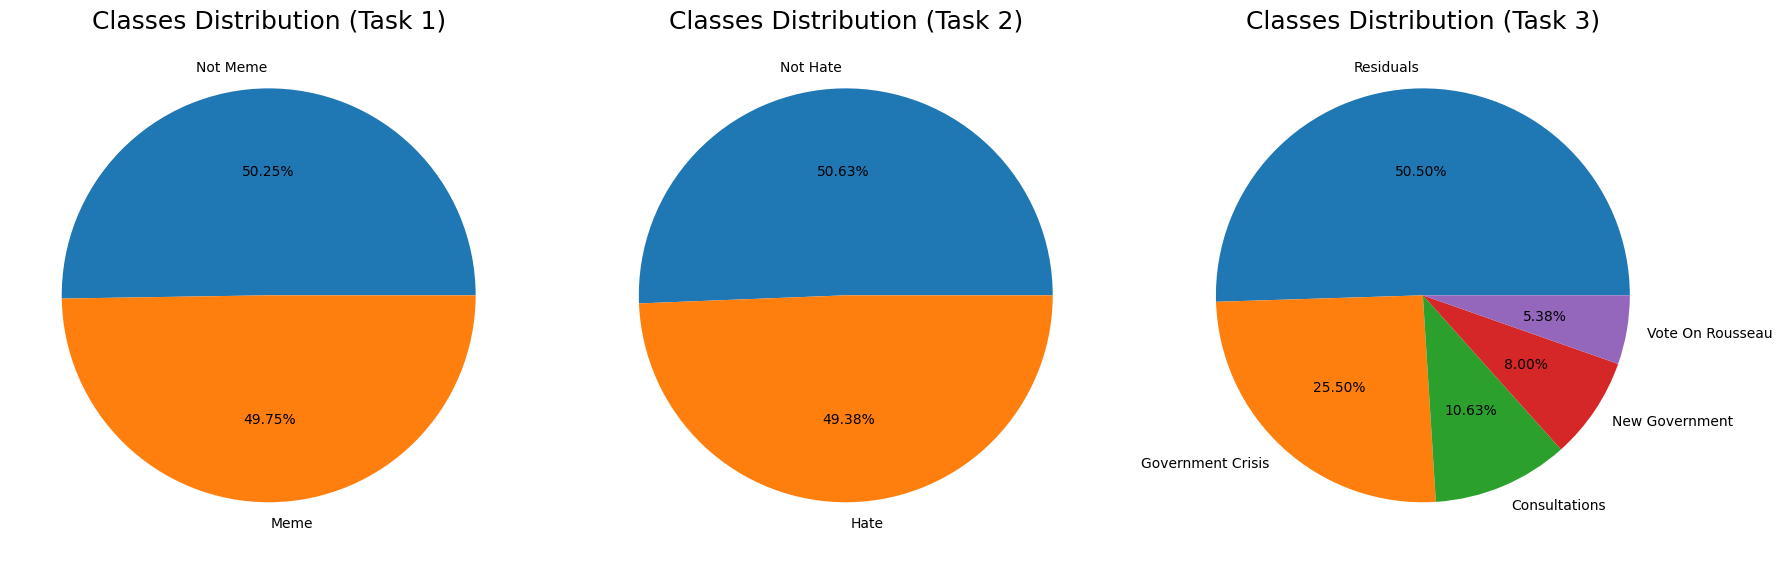

In [8]:
count1 = task_1_train['Meme'].value_counts()
count2 = task_2_train['Hate Speech'].value_counts()
count3 = task_3_train['Event'].value_counts()

labels1 = ['Not Meme', 'Meme']
labels2 = ['Not Hate', 'Hate']
labels3 = ['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau']

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
ax1.pie(count1, labels=labels1, autopct = '%1.2f%%')
ax2.pie(count2, labels=labels2, autopct = '%1.2f%%')
ax3.pie(count3, labels=labels3, autopct = '%1.2f%%')
ax1.set_title('Classes Distribution (Task 1)', fontsize = 18)
ax2.set_title('Classes Distribution (Task 2)', fontsize = 18)
ax3.set_title('Classes Distribution (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

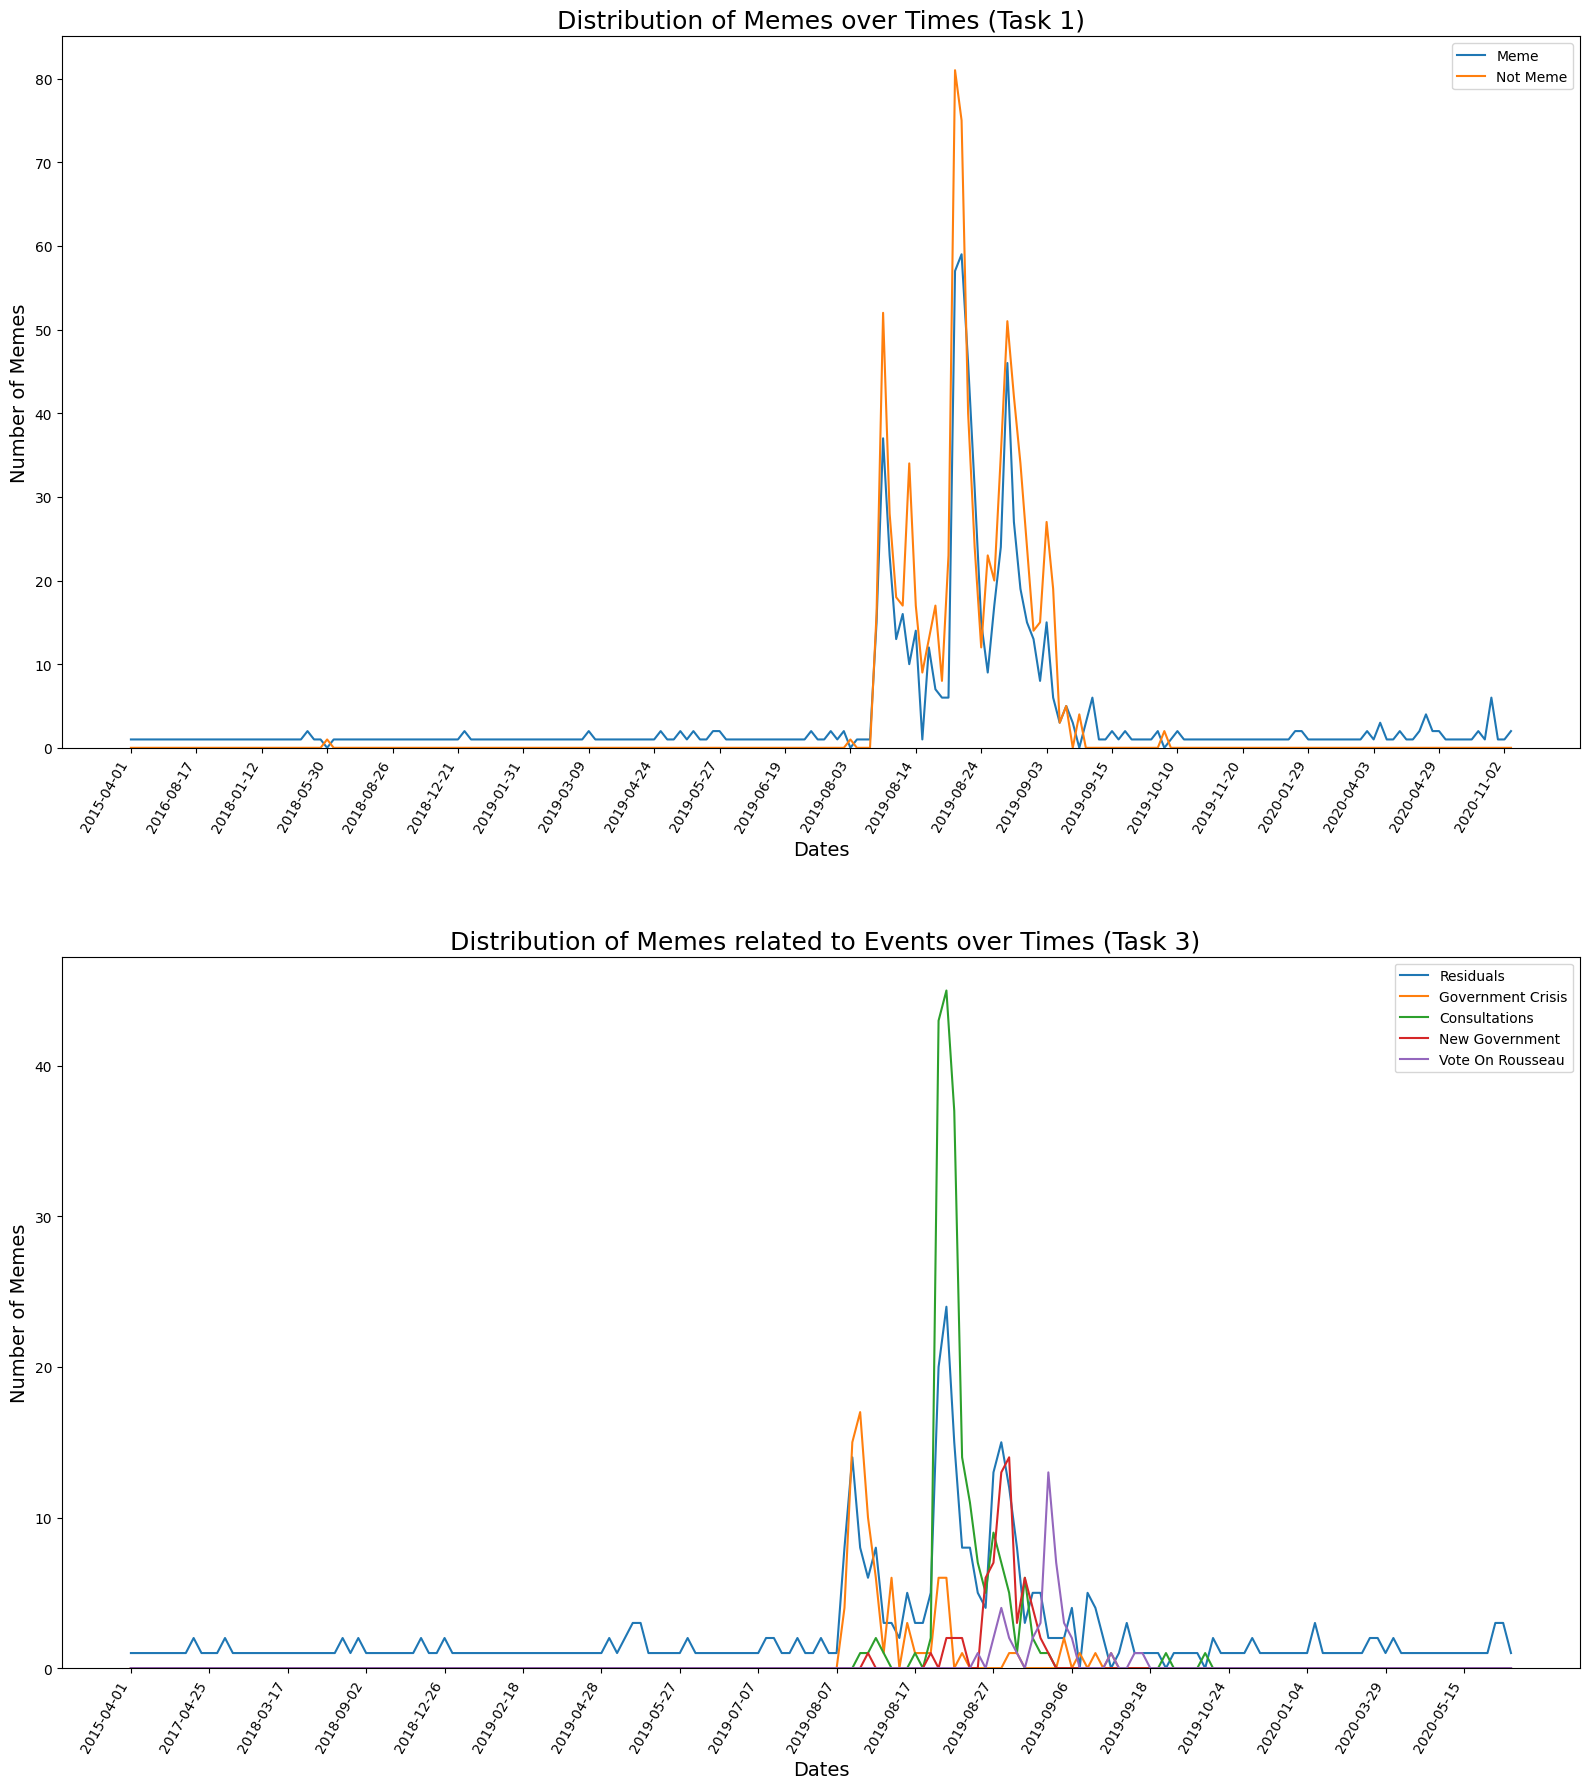

In [9]:
not_memes_by_date = task_1_train[task_1_train['Meme'] == 0].groupby('Date').size()
memes_by_date = task_1_train[task_1_train['Meme'] == 1].groupby('Date').size()
df1 = pd.DataFrame(index=pd.concat([not_memes_by_date, memes_by_date], axis=1).index, columns=['Meme','Not Meme'])
df1.loc[not_memes_by_date.index, 'Not Meme'] = not_memes_by_date.values
df1.loc[memes_by_date.index, 'Meme'] = memes_by_date.values
df1 = df1.sort_index()
df1 = df1.fillna(0)

class_0_by_date = task_3_train[task_3_train['Event'] == 0].groupby('Date').size()
class_1_by_date = task_3_train[task_3_train['Event'] == 1].groupby('Date').size()
class_2_by_date = task_3_train[task_3_train['Event'] == 2].groupby('Date').size()
class_3_by_date = task_3_train[task_3_train['Event'] == 3].groupby('Date').size()
class_4_by_date = task_3_train[task_3_train['Event'] == 4].groupby('Date').size()
df2 = pd.DataFrame(index=pd.concat([class_0_by_date, class_1_by_date, class_2_by_date, class_3_by_date, class_4_by_date], axis=1).index,
                   columns=['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau'])
df2.loc[class_0_by_date.index, 'Residuals'] = class_0_by_date.values
df2.loc[class_1_by_date.index, 'Government Crisis'] = class_1_by_date.values
df2.loc[class_2_by_date.index, 'Consultations'] = class_2_by_date.values
df2.loc[class_3_by_date.index, 'New Government'] = class_3_by_date.values
df2.loc[class_4_by_date.index, 'Vote On Rousseau'] = class_4_by_date.values
df2 = df2.sort_index()
df2 = df2.fillna(0)


fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(16, 18))
ax1.plot(df1.index, df1['Meme'], label='Meme')
ax1.plot(df1.index, df1['Not Meme'], label='Not Meme')
ax1.set_xlabel('Dates', fontsize = 14)
ax1.set_ylabel('Number of Memes', fontsize = 14)
ax1.set_xticks([df1.index[i] for i in range(0,len(df1.index),10)])
ax1.set_xticklabels([df1.index[i] for i in range(0,len(df1.index),10)], rotation = 60, ha="right")
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper right')
ax1.set_title('Distribution of Memes over Times (Task 1)', fontsize = 18)
ax2.plot(df2.index, df2['Residuals'], label='Residuals')
ax2.plot(df2.index, df2['Government Crisis'], label='Government Crisis')
ax2.plot(df2.index, df2['Consultations'], label='Consultations')
ax2.plot(df2.index, df2['New Government'], label='New Government')
ax2.plot(df2.index, df2['Vote On Rousseau'], label='Vote On Rousseau')
ax2.set_xlabel('Dates', fontsize = 14)
ax2.set_ylabel('Number of Memes', fontsize = 14)
ax2.set_xticks([df2.index[i] for i in range(0,len(df2.index),10)])
ax2.set_xticklabels([df2.index[i] for i in range(0,len(df2.index),10)], rotation = 60, ha="right")
ax2.set_ylim(ymin=0)
ax2.legend(loc='upper right')
ax2.set_title('\n\n Distribution of Memes related to Events over Times (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

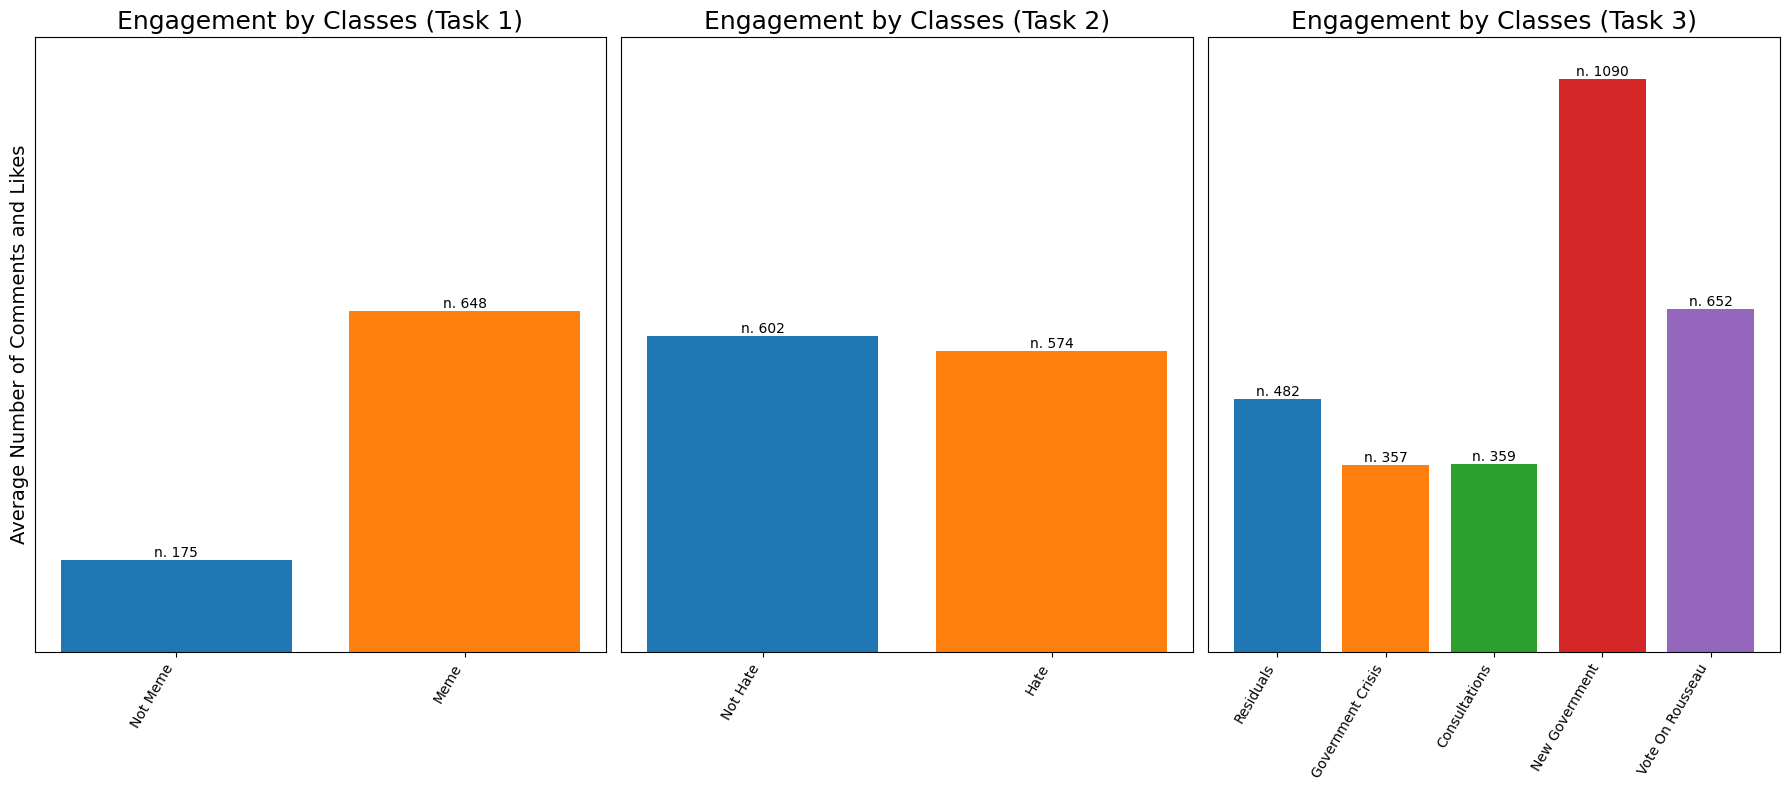

In [10]:
height1 = [
    task_1_train[task_1_train['Meme'] == 0]['Engagement'].mean(),
    task_1_train[task_1_train['Meme'] == 1]['Engagement'].mean()
]
height2 = [
    task_2_train[task_2_train['Hate Speech'] == 0]['Engagement'].mean(),
    task_2_train[task_2_train['Hate Speech'] == 1]['Engagement'].mean()
]
height3 = [
    task_3_train[task_3_train['Event'] == 0]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 1]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 2]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 3]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 4]['Engagement'].mean(),
]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels1, height=height1, color=colors)
ax1.set_ylabel('Average Number of Comments and Likes', fontsize = 14)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars2 = ax2.bar(labels2, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars3 = ax3.bar(labels3, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_title('Engagement by Classes (Task 1)', fontsize = 18)
ax2.set_title('Engagement by Classes (Task 2)', fontsize = 18)
ax3.set_title('Engagement by Classes (Task 3)', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+80))
ax2.set_ylim(ymin=0, ymax=(max(height3)+80))
ax3.set_ylim(ymin=0, ymax=(max(height3)+80))
ax1.set_xticklabels(labels1, rotation = 60, ha="right")
ax2.set_xticklabels(labels2, rotation = 60, ha="right")
ax3.set_xticklabels(labels3, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

#**2) PRE-PROCESSING**

---


In [11]:
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = stopwords.words('italian')

r = requests.get(BASE_PATHS[1] + FILENAMES[12])
swear_words = r.content.decode()

In [12]:
def my_preprocessing(sentence, hashtag=False, explicit=True, lemmatization=True):

    #1 Normalization
    if hashtag:
        sentence = ' '.join(re.sub("@\w+|#\w+", "", sentence).split())

    if explicit:
        matches = re.findall('\w+\*+\w+|\w+x+\w+', sentence)
        for m in matches:
            sentence = sentence.replace(m, get_explicit(m))

    #2 Tokenization
    tokens = nlp(sentence)

    #3 Cleaning (removing punctuation and stop words)
    tokens = [ word.text for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations and "." not in word and "'" not in word ]
    tokens = [ word for word in tokens if len(word) > 2]

    #4 Lemmatization
    if lemmatization:
        tokens = [w.lemma_.lower() for w in nlp(' '.join(tokens))]

    return tokens

In [13]:
# This function convert a user censored bad word (i.e. "sei una m***a")
# with an equivalent one taken from a list of italian bad words
# according to the same initial and final uncesored letters and to the same POS tag (where possible!)
def get_explicit(censored):
    explicit = ''
    start = censored.split('*')[0] if '*' in censored else censored.split('x')[0]
    end = censored.split('*')[-1] if '*' in censored else censored.split('x')[-1]
    pattern = '\\b, '+start+'[a-z]*'+end+'\\b'
    all = ' '.join([w[2:] for w in re.findall(pattern, swear_words)])
    if all:
        options = [o for o in nlp(all)]
        options_tag_check = [o for o in nlp(all) if o.tag_ is nlp(censored)[0].tag_]
        if len(options_tag_check):
            explicit = random.choice(options_tag_check).text
        else:
            explicit = random.choice(options).text
    return explicit

In [14]:
for i in task_2_train.sample(n=10)['Text']:
    print(f'{"ORIGINAL:":<20}{i}')
    print(f'{"PROCESSED:":<20}{my_preprocessing(i)}')
    print(f'{"NO_LEMMATIZATION:":<20}{my_preprocessing(i, lemmatization=False)}')
    print('\n')

ORIGINAL:           -sto partito non se scioje co' un par de vaffanculo
PROCESSED:          ['-sto', 'partito', 'scioje', 'par', 'vaffanculo']
NO_LEMMATIZATION:   ['-sto', 'partito', 'scioje', 'par', 'vaffanculo']


ORIGINAL:           prima gli italiani starter pack. padania is not italy. senti che puzza scappano anche i cani. prima il nord. terroni e nergi stessa merda noi con salvini
PROCESSED:          ['prima', 'italiano', 'starter', 'pack', 'padania', 'not', 'italy', 'sentire', 'puzza', 'scappare', 'cane', 'prima', 'nord', 'terrone', 'nergo', 'stesso', 'merda', 'salvini']
NO_LEMMATIZATION:   ['prima', 'italiani', 'starter', 'pack', 'padania', 'not', 'italy', 'senti', 'puzza', 'scappano', 'cani', 'prima', 'nord', 'terroni', 'nergi', 'stessa', 'merda', 'salvini']


ORIGINAL:           italia, 4 settembre 2019 un disoccupato attente l'apertura di un centro per l'impiego, nella speranza di ottenere almeno il reddito di cittadinanza.
PROCESSED:          ['italia', 'settembre', '2019',

#**3) FEATURES EXTRACTION**

---


In [15]:
data = task_2_train

## **Text Processed**

In [16]:
data['Tokens'] = data['Text'].apply(lambda x:' '.join(my_preprocessing(x)))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Text,Tokens,Hate Speech
540,1540.jpg,5359,0,Mattarella,"basta, mi avete rotto tutti le palle. affido i...",bastare rompere palla affido governo palpatine...,1
418,1418.jpg,54,0,Mattarella,"intanto, di nascosto...",intanto nascosto,0
6,1006.jpg,9,1,Renzi,coglionissimo me,cogliono,1
647,1647.jpg,5547,0,0,"muovetevi per dio, abbiamo lasciato un'altra v...",muovetevi dio lasciare altro volta cervello to...,1
580,1580.jpg,320,1,Mattarella,siamo davanti a un burrone,davanti burrone,0
730,1730.jpg,182,1,Salvini,se so' messi d'accordo. che vor di? che te la ...,mettere accordo vor pii nder culo,1
142,1142.jpg,8,1,Salvini,maalox,maalox,0
65,1065.jpg,2,0,Salvini,only big black cock,only big black cock,1
9,1009.jpg,151,1,Salvini,alzati lazzarone e vai a lavorare!,alzare lazzarone vaire lavorare,1
351,1351.jpg,2,1,Di Maio,di maio vuole fare il ministro dell'interno !,maio volere fare ministro interno,0


## **Word Cloud**

In [17]:
hateful_meme_tokens = data[data['Hate Speech']==1]['Tokens'].tolist()
nonhateful_meme_tokens = data[data['Hate Speech']==0]['Tokens'].tolist()

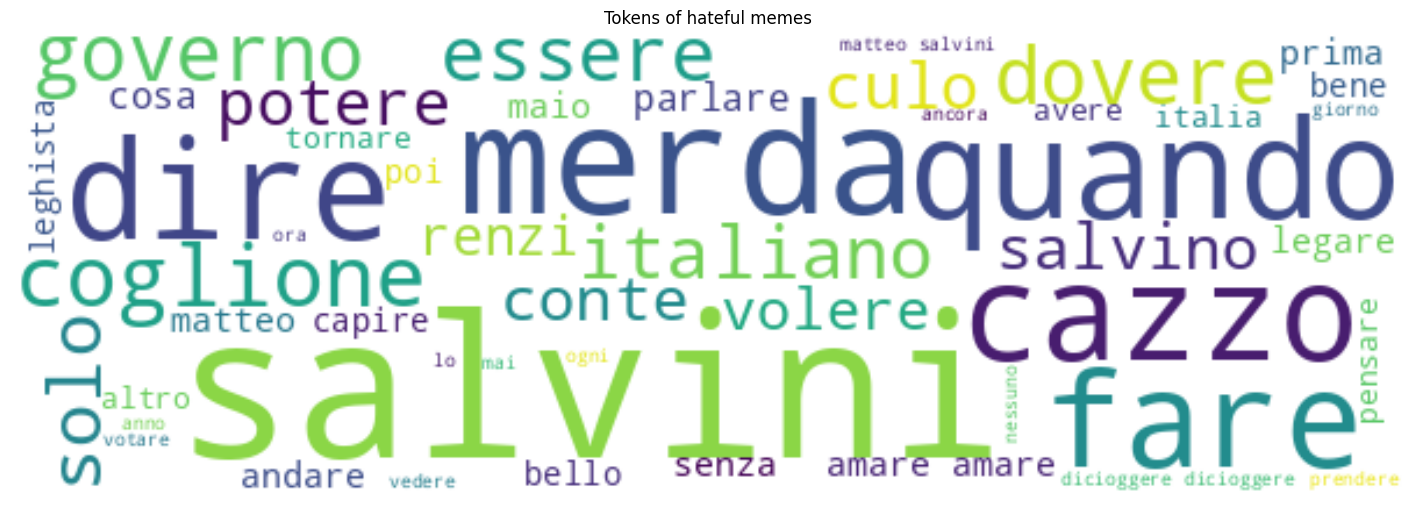

In [18]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(hateful_meme_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tokens of hateful memes")
plt.show()

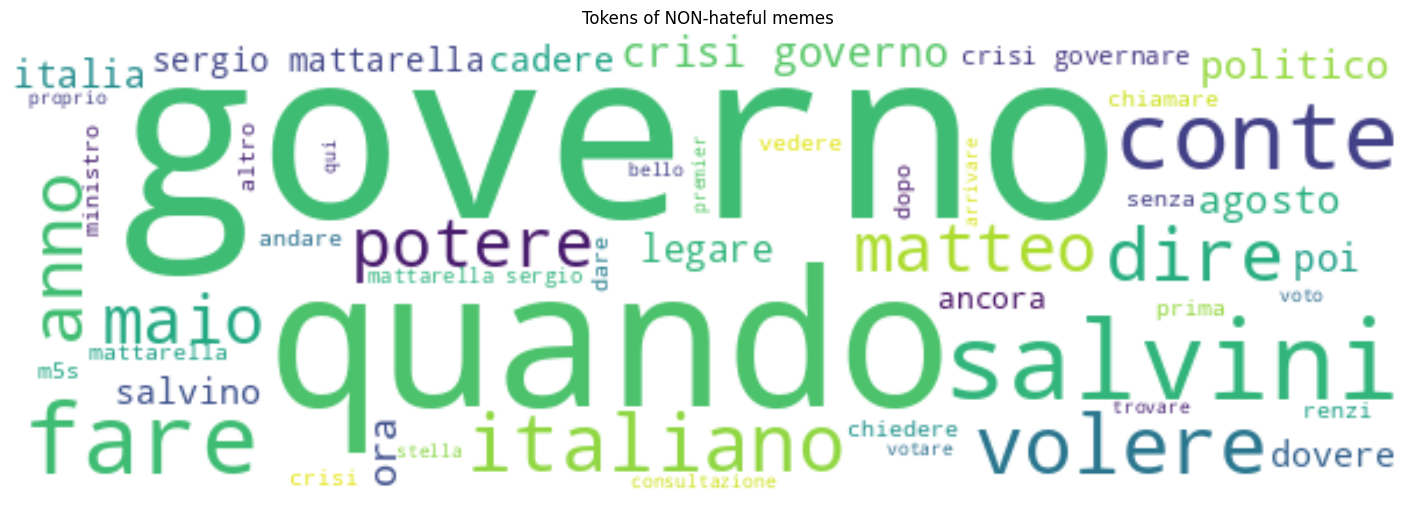

In [19]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(nonhateful_meme_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tokens of NON-hateful memes")
plt.show()

## **Hate Score**

The hate score is given by the difference between the number of hate meme and the number of not hate meme for each of the people in 'Visual' column.

In [20]:
visuals = task_2_train['Visual']
people = []
for i in visuals:
    s = i.split(',')
    s = [j.strip() for j in s if j != ' ' and j != '']
    for e in s:
        if (e is not '0' and e.title() not in people):
            people.append(e.title())

df3 = pd.DataFrame(index=[p.title() for p in people], columns=['Hate Meme','Not Hate Meme','Hate Score'])
for p in people:
    all_by_person = task_2_train[task_2_train['Visual'].str.contains(p, case=False)]
    df3.loc[p, 'Hate Meme'] = 0-len(all_by_person[task_2_train['Hate Speech'] == 1])
    df3.loc[p, 'Not Hate Meme'] = len(all_by_person[task_2_train['Hate Speech'] == 0])
    df3.loc[p, 'Hate Score'] = len(all_by_person[task_2_train['Hate Speech'] == 0]) - len(all_by_person[task_2_train['Hate Speech'] == 1])

df3 = df3.sort_values('Hate Score')
df3.sample(n=10)

,Hate Meme,Not Hate Meme,Hate Score
Delrio,-1,0,-1
Pd,-6,8,2
Tajani,-1,0,-1
Cuperlo,-1,0,-1
Gentiloni,-2,1,-1
Civati,-1,1,0
Bernini,-1,1,0
Draghi,0,1,1
Merkel,-1,0,-1
Meloni,-8,10,2


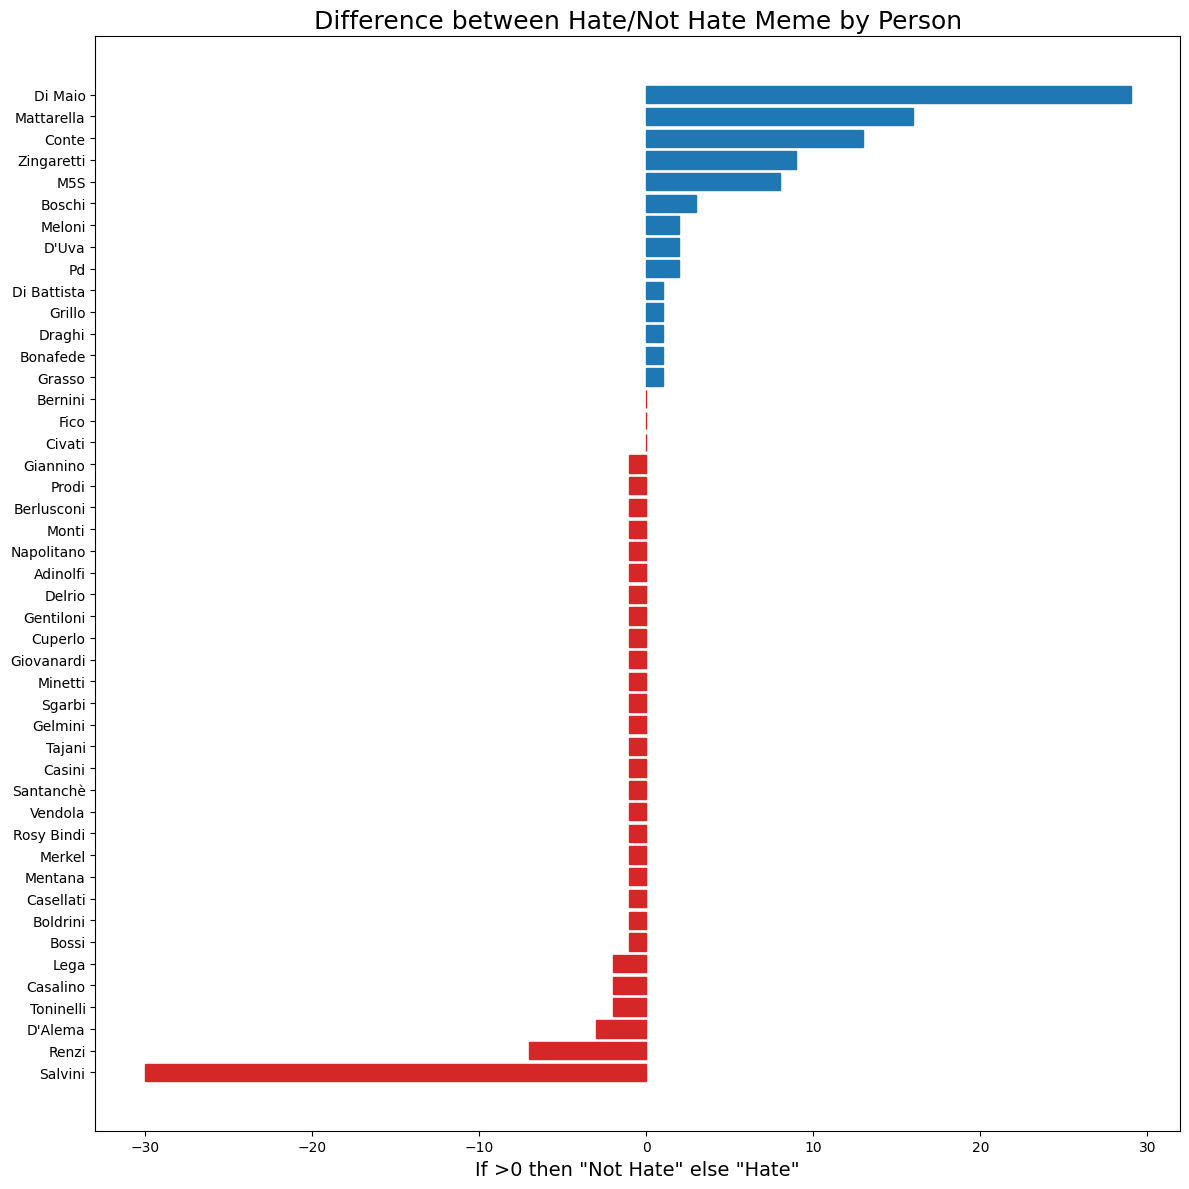

In [21]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.barh(df3.index, width=df3['Hate Score'], color=colors)
ax1.set_xlabel('If >0 then "Not Hate" else "Hate"', fontsize = 14)
for rect in bars1:
    width = rect.get_width()
    if (width > 0):
        rect.set_color('tab:blue')
    else:
        rect.set_color('tab:red')

ax1.set_title('Difference between Hate/Not Hate Meme by Person', fontsize = 18)
plt.tight_layout()
plt.show()

In [22]:
# The hate score is given by the difference between the number of
# hate meme and the number of not hate meme for each of the people in 'Visual' column
def get_hate_score(visual, score_df):
    score = np.NAN
    if (visual != '0'):
        visual = visual.split(',')
        visual = [j.strip().title() for j in visual if j != ' ' and j != '' and j != '0']
        score = score_df.loc[visual, 'Hate Score'].sum()
    return score

data['Hate Score'] = data['Visual'].apply(lambda x:get_hate_score(x, df3))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Hate Speech
40,1040.jpg,91,1,Mattarella,16.0,"oh oh! non dirmelo, è caduto il governo vero? ...",dirmelo cadere governo vero già momento consul...,0
521,1521.jpg,13,1,Salvini,-30.0,"""chi non digiuna e non lotta è un gran figlio ...",digiuno lotta gran figlio mignotto gandhinare,1
377,1377.jpg,10,0,0,NaN,sagre e selfie figure di merda felpe bacioni n...,sagra selfie figura merda felpa bacione nutell...,1
782,1782.jpg,18,0,Mattarella,16.0,5 giorni e poi li manno tutti affanculo,giorno poi manno affanculo,1
111,1111.jpg,15,0,0,NaN,"vladimir, ti interessa l'affare immigrati? asc...",vladimir interessare affare immigrato ascolto ...,1
776,1776.jpg,51,1,Salvini,-30.0,salvini carabiniere. salvini poliziotto. salvi...,salvini carabiniere salvini poliziotto salvini...,1
701,1701.jpg,19,0,"Di Maio, Salvini, Conte",12.0,era un anno bellissimo!,anno bello,0
14,1014.jpg,46,0,0,NaN,ma quindi fate il governo coi grillini? sorrid...,quindi fare governo grilline sorridi guardare ...,0
57,1057.jpg,467,1,Salvini,-30.0,"ciao piccolo, la vuoi la barchetta? cose a cas...",ciao piccolo volere barchetta cosa salvini,0
139,1139.jpg,50,0,Salvini,-30.0,a noi gabbiani de roma ce piace rovista' nella...,gabbiano roma piacere rovista monnezza mmerda,1


## **Number of Words**

The number of words calculated for the original 'Text' column's data.

In [23]:
data['Nr Words Text'] = data['Text'].apply(lambda x:len(str(x).split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words Text', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words Text,Hate Speech
656,1656.jpg,426,1,Salvini,-30.0,"cinque minuti, potresti fare il ministro dell'...",cinque minuto potresti fare ministro interno c...,10,0
157,1157.jpg,604,0,Salvini,-30.0,chi per la fretta caca nell'ortica spesso il c...,fretta caca ortico spesso culo formico,11,1
93,1093.jpg,456,1,0,NaN,1 sergio mattarella 2 sergio mattarella 3 serg...,sergio mattarella sergio mattarella sergio mat...,30,0
714,1714.jpg,34,0,0,NaN,italian crisis,italian crisis,2,0
641,1641.jpg,25,0,Conte,13.0,dadaumpa #lepiubellefrasidiosho,dadaumpa lepiubellefrasidiosho,2,0
743,1743.jpg,13,0,0,NaN,"di maio, salvini",maio salvini,3,0
368,1368.jpg,168,1,0,NaN,"sto tornando, merde!",tornare merda,3,1
179,1179.jpg,94,0,"Salvini, Renzi",-37.0,matteo matteo che rimprovera matteo. matteo co...,matteo matteo rimproverare matteo matteo confu...,13,0
333,1333.jpg,138,0,0,NaN,elezioni trash caffettuccio gratis per tutti a...,elezione trash caffettuccio gratis 17:00 tribu...,34,0
566,1566.jpg,83,1,Di Maio,29.0,retromarcia sulla tav decreto sicurezza bis re...,retromarcia tav decreto sicurezza bis regalare...,16,0


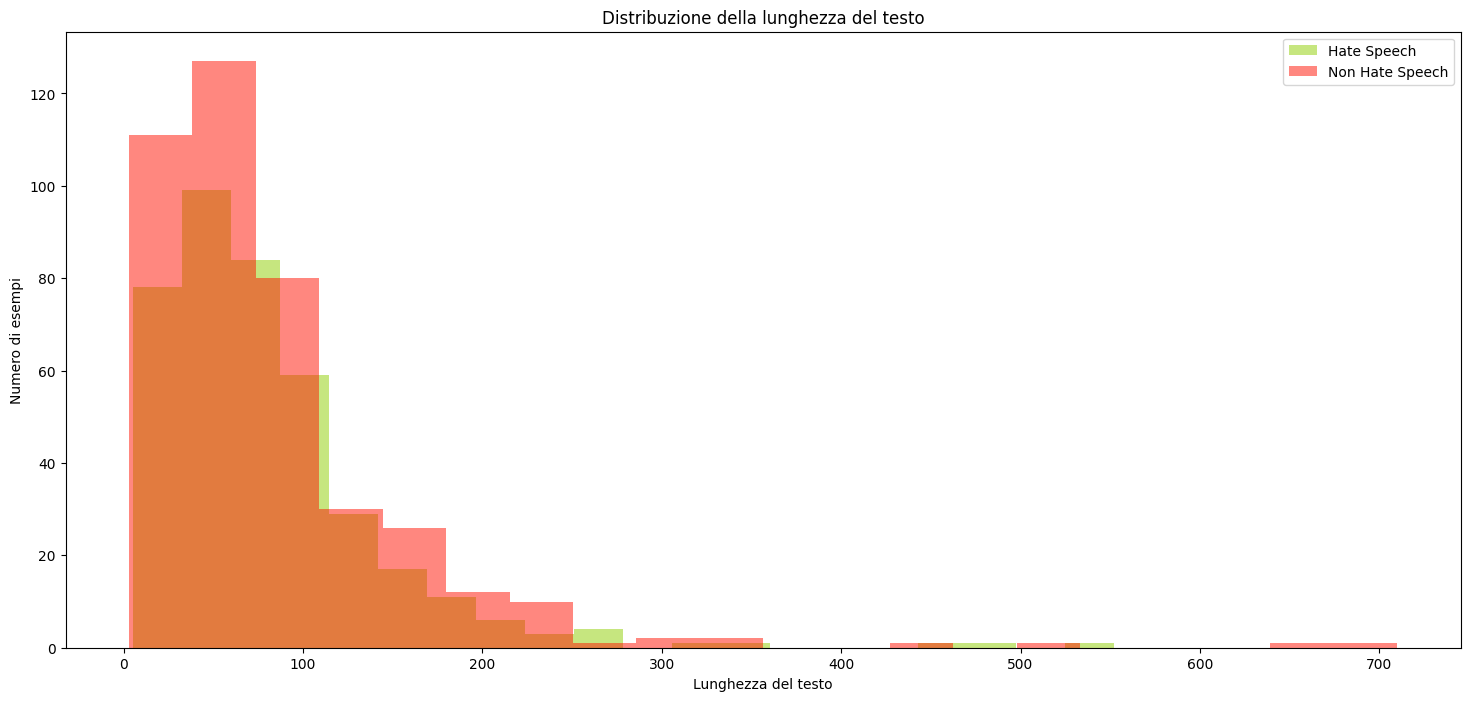

In [24]:
# Visualizzo la lunghezza del testo dei meme e delle immagini che non sono meme
# Filtra il dataset per i valori con meme = 1
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]

# Calcola la lunghezza del testo per i valori con meme = 1
meme_dataset['Nr Words Text'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Nr Words Text'] = non_meme_dataset['Text'].apply(len)

# Crea il plot della lunghezza del testo per meme e non meme
plt.hist(meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Lunghezza del testo')
plt.ylabel('Numero di esempi')
plt.title('Distribuzione della lunghezza del testo')
plt.legend()
plt.show()

## **NER**

In [25]:
tokens = data['Tokens']
df4 = pd.DataFrame(columns=['File Id','Entity Name','Entity Label'])
for t in tokens:
    spacy_tokens = nlp(t)
    if spacy_tokens.ents:
        names = []
        labels = []
        for ent in spacy_tokens.ents:
            names.append(ent.text)
            labels.append(ent.label_)
        list_row = [data[data['Tokens'] == t]['File'].iat[0], ', '.join(names), ', '.join(labels)]
        df4.loc[len(df4)] = list_row

df4.sample(n=10)

,File Id,Entity Name,Entity Label
242,1494.jpg,pompieriare pompierino,PER
224,1470.jpg,"renzi, zingaretto","PER, PER"
347,1729.jpg,"poero toninello arào capiho, toninelli","LOC, PER"
83,1168.jpg,"salvino, levere palla","PER, PER"
382,1793.jpg,"salvino cantass, chello granda","PER, PER"
280,1577.jpg,foto gruppo,ORG
384,1796.jpg,man woman white black poor rich asian,PER
349,1736.jpg,senato repubblica,ORG
383,1795.jpg,salvino,PER
368,1765.jpg,mattei,PER


## **Words Embedding**

## *Doc2Vec*

In [26]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['Tokens'])]
d2v = Doc2Vec(vector_size=400, window=2, min_count=1)
d2v.build_vocab(documents)

In [27]:
data['Doc2Vec'] = data['Tokens'].apply(lambda x: d2v.infer_vector(x.split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Doc2Vec', 'Nr Words Text', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[-0.00059093453, 0.0008827944, -0.0010215594, ...",15,1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[6.7998467e-06, -6.4894556e-07, -0.0009960464,...",14,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[0.0011427903, 0.00069085316, -0.0010278844, 0...",17,1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[-0.0008625564, 0.00024336457, -0.0012305622, ...",9,1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[6.3647625e-05, -0.0010660094, 0.0005115777, 0...",26,0


## *TfIdf*

In [28]:
# Tokenizzazione dei testi
documents_tfidf = [text.split() for text in data['Text']]

# Creazione del dizionario dei token
dictionary = Dictionary(documents_tfidf)

In [29]:
# Creazione del corpus
corpus_tfidf = [dictionary.doc2bow(doc) for doc in documents_tfidf]

# Calcolo della rappresentazione TF-IDF
tfidf = TfidfModel(corpus_tfidf)

In [30]:
data['TfIdf'] = [ tfidf[t] for t in corpus_tfidf ]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech,TfIdf
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[-0.00059093453, 0.0008827944, -0.0010215594, ...",15,1,"[(0, 0.323982732233108), (1, 0.323982732233108..."
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[6.7998467e-06, -6.4894556e-07, -0.0009960464,...",14,0,"[(13, 0.16049350282905558), (14, 0.20003469684..."
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[0.0011427903, 0.00069085316, -0.0010278844, 0...",17,1,"[(15, 0.04950811687373344), (27, 0.27774114363..."
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[-0.0008625564, 0.00024336457, -0.0012305622, ...",9,1,"[(15, 0.06536980888360312), (43, 0.30645430625..."
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[6.3647625e-05, -0.0010660094, 0.0005115777, 0...",26,0,"[(15, 0.03886868566702598), (16, 0.10707188329..."


## *BERT*

In [31]:
# Caricamento del modello preaddestrato BERT
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
token_embeddings = []
for text in data['Text']:
    # Tokenizzazione del testo
    tokens = tokenizer.tokenize(text)

    # Aggiunta dei token [CLS] e [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Conversione dei token in ID
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Creazione del tensore di input
    input_tensor = torch.tensor([input_ids])

    # Esecuzione del modello BERT
    with torch.no_grad():
        outputs = model(input_tensor)

    # Estrazione delle rappresentazioni vettoriali dei token
    token_embedding = outputs.last_hidden_state.squeeze(0)

    token_embeddings.append(token_embedding)

In [33]:
data['BERT'] = token_embeddings
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech,TfIdf,BERT
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[-0.00059093453, 0.0008827944, -0.0010215594, ...",15,1,"[(0, 0.323982732233108), (1, 0.323982732233108...","[[tensor(-0.5229), tensor(-0.0531), tensor(0.1..."
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[6.7998467e-06, -6.4894556e-07, -0.0009960464,...",14,0,"[(13, 0.16049350282905558), (14, 0.20003469684...","[[tensor(-0.5242), tensor(-0.1135), tensor(-0...."
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[0.0011427903, 0.00069085316, -0.0010278844, 0...",17,1,"[(15, 0.04950811687373344), (27, 0.27774114363...","[[tensor(-0.6023), tensor(0.3418), tensor(-0.0..."
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[-0.0008625564, 0.00024336457, -0.0012305622, ...",9,1,"[(15, 0.06536980888360312), (43, 0.30645430625...","[[tensor(-0.3404), tensor(-0.1730), tensor(0.2..."
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[6.3647625e-05, -0.0010660094, 0.0005115777, 0...",26,0,"[(15, 0.03886868566702598), (16, 0.10707188329...","[[tensor(-0.8017), tensor(-0.8607), tensor(0.0..."


#**4) MODEL DEFINITION**

---


## **Create final dataset with image embeddings**

In [34]:
task_2_embeddings = pd.read_csv(BASE_PATHS[1] + FILENAMES[4], header=None)
task_2_embeddings.head()

,0,1
0,1000.jpg,0.03371752053499222 0.7138307690620422 0.16221...
1,1001.jpg,0.017445266246795654 0.016754239797592163 0.06...
2,1002.jpg,0.2331690937280655 2.1796271800994873 0.0 0.00...
3,1003.jpg,0.09365507960319519 1.8714182376861572 0.52478...
4,1004.jpg,0.1272037923336029 1.260957956314087 0.1069836...


In [35]:
data['Image_embeddings'] = task_2_embeddings.loc[:][1]

def convert_to_float_list(string):
  values = string.split()
  for i in range(0, len(values)):
    values[i] = float(values[i])

    return values

data['Image_embeddings_float'] = np.array(data['Image_embeddings'].apply(convert_to_float_list))
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech,TfIdf,BERT,Image_embeddings,Image_embeddings_float
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[-0.00059093453, 0.0008827944, -0.0010215594, ...",15,1,"[(0, 0.323982732233108), (1, 0.323982732233108...","[[tensor(-0.5229), tensor(-0.0531), tensor(0.1...",0.03371752053499222 0.7138307690620422 0.16221...,"[0.03371752053499222, 0.7138307690620422, 0.16..."
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[6.7998467e-06, -6.4894556e-07, -0.0009960464,...",14,0,"[(13, 0.16049350282905558), (14, 0.20003469684...","[[tensor(-0.5242), tensor(-0.1135), tensor(-0....",0.017445266246795654 0.016754239797592163 0.06...,"[0.017445266246795654, 0.016754239797592163, 0..."
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[0.0011427903, 0.00069085316, -0.0010278844, 0...",17,1,"[(15, 0.04950811687373344), (27, 0.27774114363...","[[tensor(-0.6023), tensor(0.3418), tensor(-0.0...",0.2331690937280655 2.1796271800994873 0.0 0.00...,"[0.2331690937280655, 2.1796271800994873, 0.0, ..."
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[-0.0008625564, 0.00024336457, -0.0012305622, ...",9,1,"[(15, 0.06536980888360312), (43, 0.30645430625...","[[tensor(-0.3404), tensor(-0.1730), tensor(0.2...",0.09365507960319519 1.8714182376861572 0.52478...,"[0.09365507960319519, 1.8714182376861572, 0.52..."
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[6.3647625e-05, -0.0010660094, 0.0005115777, 0...",26,0,"[(15, 0.03886868566702598), (16, 0.10707188329...","[[tensor(-0.8017), tensor(-0.8607), tensor(0.0...",0.1272037923336029 1.260957956314087 0.1069836...,"[0.1272037923336029, 1.260957956314087, 0.1069..."


Scaling delle colonne numeriche

In [36]:
scaler = MinMaxScaler()

data['Engagement'] = scaler.fit_transform(data['Engagement'].values.reshape(-1, 1))
data['Nr Words Text'] = scaler.fit_transform(data['Nr Words Text'].values.reshape(-1, 1))

# replace Nan values with 0
data['Hate Score'] = data['Hate Score'].fillna(0)
data['Hate Score'] = scaler.fit_transform(data['Hate Score'].values.reshape(-1, 1))
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech,TfIdf,BERT,Image_embeddings,Image_embeddings_float
0,1000.jpg,0.009771,0,0,0.385417,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[-0.00059093453, 0.0008827944, -0.0010215594, ...",0.115702,1,"[(0, 0.323982732233108), (1, 0.323982732233108...","[[tensor(-0.5229), tensor(-0.0531), tensor(0.1...",0.03371752053499222 0.7138307690620422 0.16221...,"[0.03371752053499222, 0.7138307690620422, 0.16..."
1,1001.jpg,0.003642,1,0,0.385417,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[6.7998467e-06, -6.4894556e-07, -0.0009960464,...",0.107438,0,"[(13, 0.16049350282905558), (14, 0.20003469684...","[[tensor(-0.5242), tensor(-0.1135), tensor(-0....",0.017445266246795654 0.016754239797592163 0.06...,"[0.017445266246795654, 0.016754239797592163, 0..."
2,1002.jpg,0.092271,1,"Di Maio, Zingaretti, Berlusconi, Salvini",0.458333,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[0.0011427903, 0.00069085316, -0.0010278844, 0...",0.132231,1,"[(15, 0.04950811687373344), (27, 0.27774114363...","[[tensor(-0.6023), tensor(0.3418), tensor(-0.0...",0.2331690937280655 2.1796271800994873 0.0 0.00...,"[0.2331690937280655, 2.1796271800994873, 0.0, ..."
3,1003.jpg,0.004231,1,"Salvini, Renzi",0.000000,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[-0.0008625564, 0.00024336457, -0.0012305622, ...",0.066116,1,"[(15, 0.06536980888360312), (43, 0.30645430625...","[[tensor(-0.3404), tensor(-0.1730), tensor(0.2...",0.09365507960319519 1.8714182376861572 0.52478...,"[0.09365507960319519, 1.8714182376861572, 0.52..."
4,1004.jpg,0.001128,0,0,0.385417,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[6.3647625e-05, -0.0010660094, 0.0005115777, 0...",0.206612,0,"[(15, 0.03886868566702598), (16, 0.10707188329...","[[tensor(-0.8017), tensor(-0.8607), tensor(0.0...",0.1272037923336029 1.260957956314087 0.1069836...,"[0.1272037923336029, 1.260957956314087, 0.1069..."


In [37]:
X1 = data[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words Text']].values
X2 = data[['Image_embeddings_float']].values
X3 = data[['Doc2Vec']].values
X4 = data[['TfIdf']].values
X5 = data[['BERT']].values
y = data[['Hate Speech']].values

Creazione del modello

In [67]:
# Creazione del modello
model = Sequential()
model.add(Dense(128,input_dim=4, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(1, activation='tanh'))

In [68]:
# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
# Addestramento del modello
model.fit(X1, y, epochs=10, verbose=1)

Epoch 1/10
25/25 [==============================] - 3s 4ms/step - loss: 5.8860e-08 - accuracy: 0.5063
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 5.8860e-08 - accuracy: 0.5063
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 5.8860e-08 - accuracy: 0.5063
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 5.8860e-08 - accuracy: 0.5063
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: 5.8860e-08 - accuracy: 0.5063
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 5.8860e-08 - accuracy: 0.5063
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 5.8860e-08 - accuracy: 0.5063
Epoch 8/10
25/25 [==============================] - 0s 4ms/step - loss: 5.8860e-08 - accuracy: 0.5063
Epoch 9/10
25/25 [==============================] - 0s 5ms/step - loss: 5.8860e-08 - accuracy: 0.5063
Epoch 10/10
25/25 [==============================] - 0s 7ms/step - loss: 5.8860e-0